In [1]:
from copy import deepcopy
from statistics import stdev
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def graph_progress(all_costs, all_accuracies, show_recents=True):
    # last 5 results
    # ---------------
    if show_recents:
        line1 = "cost: "
        line2 = "acc:  "
        if len(all_costs) < 5: show = len(all_costs)
        else:                  show = 5
        for i in range(-show, 0):
            line1 += "{:>8} ".format(round(all_costs[i], 5))
            line2 += "{:>8}%".format(round(all_accuracies[i]*100, 2))
        print(line1)
        print(line2)


    # graphs
    # -------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].plot(range(len(all_costs)), all_costs, label="costs")
    axes[0].set_xlabel('step') # Set the y axis label of the current axis.
    axes[0].set_ylabel('cost') # Set a title of the current axes.
    axes[0].set_title('cost over training steps') 
    axes[0].legend() # show a legend on the plot

    axes[1].plot(range(len(all_accuracies)), all_accuracies, label="accuracies")
    axes[1].set_xlabel('step') # Set the y axis label of the current axis.
    axes[1].set_ylabel('accuracy') # Set a title of the current axes.
    axes[1].set_title('accuracy over training steps') 
    axes[1].legend() # show a legend on the plot

    return fig.tight_layout()

# import training data

In [3]:
import pandas as pd #1
import os           #3

In [4]:
given_data_folder = 'prepped'

file_names = os.listdir(given_data_folder)
file_names.sort()
file_names

['.DS_Store',
 'M_predictions.csv',
 'M_testing.csv',
 'M_training_data.csv',
 'M_training_data_embedding.csv',
 'W_predictions.csv',
 'W_testing.csv',
 'W_training_data.csv',
 'predictions']

In [5]:
training_data_file = 'M_training_data_embedding.csv'

In [6]:
file_path = given_data_folder + '/' + training_data_file 
training_df  = pd.read_csv(file_path)
print(len(training_df))

training_df.head(5)

46338


,team1_id,team2_id,Pts,FG%2,FGA2,FG%3,FGA3,FT%,FTA,OR,...,xFTA_a,xOR_a,xDR_a,xAst_a,xTO_a,xStl_a,xBlk_a,xPF_a,xStr_a,solution
0,11872022.0,14412022.0,0.750000,0.633800,0.787037,0.439078,0.680556,0.750842,0.662162,0.605263,...,-0.567568,-0.605263,-0.675676,-0.479167,-0.659091,-0.538462,-0.500000,-0.621212,-0.847291,1
1,14412022.0,11872022.0,0.754902,0.658602,0.555556,0.582219,0.930556,0.601307,0.594595,0.578947,...,-0.675676,-0.578947,-0.770270,-0.354167,-0.659091,-0.807692,-0.375000,-0.606061,-0.400841,-1
2,12522022.0,12592022.0,0.833333,0.763211,0.648148,0.694010,0.555556,0.798333,0.662162,0.236842,...,-0.567568,-0.657895,-0.635135,-0.687500,-0.454545,-0.615385,-0.500000,-0.606061,-0.768758,1
3,12592022.0,12522022.0,0.699346,0.750538,0.629630,0.404228,0.712963,0.706472,0.513513,0.280702,...,-0.675676,-0.543860,-0.702703,-0.569444,-0.666667,-0.615385,-0.458333,-0.545455,-0.541014,-1
4,13292022.0,13412022.0,0.700980,0.737634,0.750000,0.435882,0.583333,0.632353,0.391892,0.684211,...,-0.297297,-0.394737,-0.567568,-0.312500,-0.863636,-0.538462,-0.562500,-0.439394,-0.598615,1


## get as rows

In [7]:
# wether or not to keep the data for stats against a team
keep_against = True

In [8]:
training_column_names = training_df.columns.tolist()

# get all data as columns
training_columns = []
for i in range(len(training_column_names)):
    new_column = list(training_df[training_column_names[i]])
    training_columns.append(new_column)
    

    
# indicis
# 30 each 0:15, 15:30, 30:45, 45:60
if not keep_against:
    new_training_columns = training_columns[0:15] + training_columns[30:45] + [training_columns[60]]
    training_columns = new_training_columns
    
    
    
# get as rows
training_input_rows    = []
training_solution_rows = []
embedding_key_rows     = []
for i in range(len(training_columns[0])):
    new_input_row         = []
    new_solution_row      = [training_columns[-1][i]]
    new_embedding_key_row = [int(training_columns[0][i]), int(training_columns[1][i])]
    for j in range(2, len(training_columns)-1):
        new_input_row.append(training_columns[j][i])
        
    training_input_rows   .append(new_input_row)
    training_solution_rows.append(new_solution_row)
    embedding_key_rows    .append(new_embedding_key_row)
    
print(len(training_input_rows), len(training_input_rows[0]))
print(len(training_solution_rows), len(training_solution_rows[0]))
print(len(embedding_key_rows), len(embedding_key_rows[0]))

46338 114
46338 1
46338 2


In [9]:
split = 7_000
np_inputs    = np.array(training_input_rows[:split])
np_solutions = np.array(training_solution_rows[:split])

embedding_key_rows = embedding_key_rows[:split]

#np_inputs    = np.array(training_input_rows)
#np_solutions = np.array(training_solution_rows)

np_data = [np_inputs, np_solutions]

# Create and Train population

In [10]:
import sys
sys.path.append("../../..")

from network_matrix.population_v3 import Population
from network_matrix.population_v3 import create_embedding

### create embeddings

In [11]:
embedding_length = 75

unique_team_ids = []
embeddings_dict = {}
for i in range(len(embedding_key_rows)):
    row = embedding_key_rows[i]
    
    for team in row:
        if team not in unique_team_ids:
            unique_team_ids.append(team)
            embeddings_dict[team] = create_embedding(embedding_length, init_range=1.0)
        
embeddings_dict[11872022]

array([ 0.6586467 ,  0.3798173 , -0.79908   , -0.2773201 , -0.97297245,
       -0.5205656 ,  0.2665245 ,  0.2596843 , -0.3050352 , -0.77887243,
        0.11896353,  0.3375049 ,  0.23917578,  0.27832744,  0.95084614,
        0.23632239,  0.80453986, -0.6146963 , -0.8311841 ,  0.18898907,
        0.0929279 ,  0.93859553,  0.14376307,  0.711651  ,  0.01112569,
        0.9860521 ,  0.36727256, -0.59089035,  0.32101175,  0.6510694 ,
        0.01111768,  0.9743364 , -0.21381907,  0.46437874, -0.7945986 ,
       -0.7579802 , -0.56646526, -0.93482554,  0.17873868, -0.34347188,
        0.7610254 ,  0.11180535, -0.225381  ,  0.44464293, -0.7253598 ,
        0.8363989 ,  0.90624255, -0.9147598 ,  0.40974706,  0.925536  ,
       -0.04075904,  0.6879139 , -0.07791705,  0.38305792, -0.9443535 ,
       -0.0986512 , -0.4771773 ,  0.9782801 , -0.12157764, -0.35868374,
        0.14840595,  0.08078104,  0.02181147,  0.6479078 , -0.8367503 ,
       -0.0951722 , -0.11722691,  0.42382368, -0.6526953 ,  0.12

In [20]:
embeddings_dict[11872022]

array([ 0.02157759,  0.6483883 ,  0.14364906,  0.09035692, -0.12123352,
       -0.43681282,  0.04650299, -0.93639565, -0.19044226,  0.1799832 ,
        0.01213782, -0.05558179,  0.8238375 ,  0.4998128 ,  0.6785987 ,
        0.81655836,  0.5363494 , -0.85091805,  0.11168158, -0.3000549 ,
       -0.1024701 ,  0.1738263 , -0.92336214, -0.39101973, -0.7861493 ,
        0.12137592, -0.09399392,  0.90383184,  0.5522422 ,  0.86117065,
       -0.33645487,  0.27415696,  0.54659486, -0.2675567 ,  0.14792085,
        0.08065153, -0.7455556 , -0.31134886, -0.07912376,  0.89161694,
        0.18373238, -0.4017597 ,  0.90919954, -0.2490196 , -0.20061143,
        0.85521275, -0.44987896,  0.28702408, -0.46672562, -0.9352145 ,
        0.30376363,  0.03462115,  0.67048705,  0.42113438,  0.13357627,
       -0.50825447,  0.52334106,  0.3651401 , -0.66202646,  0.6542599 ,
        0.33360374, -0.0610722 ,  0.6272555 , -0.4343993 , -0.14527299,
       -0.48435324,  0.4121263 ,  0.62738544, -0.82127905, -0.85

### create it here

In [13]:
'''
learning_rate, steps, batch_size,    cost,      acc,
-------------- ------ ----------- -------- ---------
       0.0001,    50,          2,   0.215,   65.51%,
       
       0.0001     50,          2,   0.190,   71.27%,  # recent 5 games, no stats against
       0.0001    100,          2,   0.188,   71.19%,  # recent 5 games, with stats against
''';

num_inputs = len(np_inputs[0]) + (2*embedding_length)
num_inputs

264

In [24]:
7*60*60

25200

In [15]:
TEST_population  = Population(num_inputs, 1, learning_rate=0.00001)

all_times = [0,0,0,0,0]
all_costs = []
all_accuracies = []

In [25]:
# training loops
# ---------------
#times, costs, accuracies = TEST_population.train_and_test(np_data, 6_000)
#times, costs, accuracies = TEST_population.train_and_test_stochastic(np_data, 100, batch_size=10)

times, data, costs, accuracies = TEST_population.train_and_test_embeddings(np_inputs, embedding_key_rows, 
                                                                           np_solutions, 
                                                                           embeddings_dict, 
                                                                           steps=9000,
                                                                           training_time=25200,
                                                                           use_time=True,
                                                                           report_frequency=5)


# update tracking
# ---------------
for i in range(len(all_times)):
    all_times[i] += times[i]
all_costs      += costs
all_accuracies += accuracies

Training Progress:                             |    cost     acc  |     steps           time      remaining  
                                               | --------  ------ | ----------  -------------  ------------- 


 
                 time(s)   percent  per step       | steps:             1309
            ------------  --------  --------       | learning rate:    1e-05
set inputs      6m 52.8s      1.64%     0.05       | # connections:   348744
calc value   1h 33m 17.2s      22.2%     0.62       | L1 (sum):          -0.0
grad dscnt   2h 56m 10.6s     41.92%     1.17       | L2 (**2):        0.0013
update vals  2h  3m 44.6s     29.44%     0.82
scoring        19m 48.9s      4.71%     0.13       
step time    8h 18m 19.6s     100.0%     3.32

cost:   0.1837  0.18403  0.18372  0.18506  0.18356 
acc:     71.24%   71.24%   71.33%   70.91%   71.27%


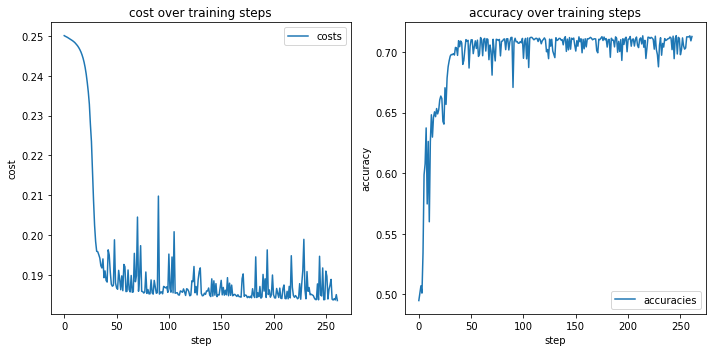

In [26]:
TEST_population.report_training_progress(all_times, data) # timing
graph_progress(all_costs, all_accuracies)                 # graphs
#graph_progress(all_costs[70:], all_accuracies[70:], show_recents=False) # graphs (recent)

In [18]:
TEST_population.print_magnitudes_report()


           abs_avg   abs_med       sum       max       min
          --------  --------  --------  --------  --------
values       0.393     0.354    -5.546     0.897    -0.939
biases       0.001     0.001     0.031     0.009    -0.009
weights      0.024     0.015    -1.079     0.215    -0.218
          --------  --------  --------  --------  --------
values       0.202     0.168     2.375     0.602    -0.657
biases       0.001       0.0    -0.035      0.01    -0.015
weights      0.024     0.015   -19.267     0.232    -0.242
          --------  --------  --------  --------  --------
values       0.116     0.093     6.176     0.445    -0.371
biases         0.0       0.0     -0.04     0.003    -0.008
weights      0.024     0.015     8.305     0.218    -0.228
          --------  --------  --------  --------  --------
values       0.065     0.051     3.607     0.235     -0.24
biases         0.0       0.0    -0.015     0.004    -0.003
weights      0.024     0.015    -2.072     0.192    -0.

In [19]:
'''
create embeddings
calculate num inputs
create test population
record values

values:
--------

steps/time
learning rate     - [0.01, 0.001, 0.0001]

embedding size    - [50, 75, 100]
neurons per layer - [1, 1.5, 2]
layers            - [1,2,3]

cost
accuracy



''';